In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pathlib
import seaborn as sns
import pathlib
# to use r2 as loss function (dont work yet)
from torchmetrics.functional import r2_score as r2_loss
from torcheval.metrics.functional import r2_score
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import logging
from copy import copy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# read csv and craete pd dataframe
csv_path = pathlib.Path("./data/2022_Test_ML.csv")
df = pd.read_csv(csv_path)
df = df.drop(["ind"], axis=1)

In [4]:
df.head

<bound method NDFrame.head of          s_mt      s_mq         d       h_p           QW           DP
0    1.409218  1.954108  2.867735  7.811623  1504.175621   501.563016
1    1.382565  2.006212  1.545090  8.124248  1240.530500   377.163158
2    1.622445  1.386172  1.192385  7.354709  1385.191155   457.404772
3    1.786172  1.591984  2.350701  4.324649  1602.841975  1429.795145
4    1.995591  2.024449  1.208417  6.993988  1326.290979   514.009143
..        ...       ...       ...       ...          ...          ...
495  0.994188  0.898998  1.276553  7.450902  1372.713745   427.058560
496  2.067936  1.094389  2.198397  4.396794  1485.744424  1201.422759
497  1.847094  1.287174  2.134269  9.939880  1573.955147   344.570374
498  1.458717  1.057916  1.044088  9.110220  1090.437833   314.558218
499  0.811423  1.146493  2.106212  6.513026  1646.376404   671.620077

[500 rows x 6 columns]>

In [5]:
ranges_dict: dict = {
    "s_mt": {
        "max": 2.7,
        "min": 0.8
    },
    "s_mq": {
        "max": 2.1,
        "min": 0.8
    },
    "d": {
        "max": 3.0,
        "min": 1.0
    },
    "h_p": {
        "max": 10.0,
        "min": 4.0
    }
}
def filter_df(df:pd.DataFrame, input_variation_range: dict, column_name: str) -> pd.DataFrame:
    return df[(df[column_name] >= input_variation_range["min"]) & (df[column_name] <= input_variation_range["max"])]    
    

In [6]:
# checking if all features are in the range
featueres = ["s_mt", "s_mq", "d", "h_p"]
for feature in featueres:
    df = filter_df(df, ranges_dict.get(feature), feature)
    print(len(df))

500
500
500
500


In [7]:
# 
df.head

<bound method NDFrame.head of          s_mt      s_mq         d       h_p           QW           DP
0    1.409218  1.954108  2.867735  7.811623  1504.175621   501.563016
1    1.382565  2.006212  1.545090  8.124248  1240.530500   377.163158
2    1.622445  1.386172  1.192385  7.354709  1385.191155   457.404772
3    1.786172  1.591984  2.350701  4.324649  1602.841975  1429.795145
4    1.995591  2.024449  1.208417  6.993988  1326.290979   514.009143
..        ...       ...       ...       ...          ...          ...
495  0.994188  0.898998  1.276553  7.450902  1372.713745   427.058560
496  2.067936  1.094389  2.198397  4.396794  1485.744424  1201.422759
497  1.847094  1.287174  2.134269  9.939880  1573.955147   344.570374
498  1.458717  1.057916  1.044088  9.110220  1090.437833   314.558218
499  0.811423  1.146493  2.106212  6.513026  1646.376404   671.620077

[500 rows x 6 columns]>

In [8]:
df.corr()

,s_mt,s_mq,d,h_p,QW,DP
s_mt,1.000000,0.002774,-0.002534,0.002058,-0.018162,-0.005937
s_mq,0.002774,1.000000,0.003271,0.002259,-0.028739,-0.007786
d,-0.002534,0.003271,1.000000,-0.003678,0.449105,0.189363
h_p,0.002058,0.002259,-0.003678,1.000000,-0.632678,-0.898030
QW,-0.018162,-0.028739,0.449105,-0.632678,1.000000,0.743292
DP,-0.005937,-0.007786,0.189363,-0.898030,0.743292,1.000000


In [9]:
a = [1,2,3,4,5,6]
print(a[:-2])
print(a[-2:])

[1, 2, 3, 4]
[5, 6]


In [10]:
# custom dataset for splitting between train and test batches
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data: pd.DataFrame, transfrom = None):
        self.data: pd.DataFrame = data
        self.transform = transfrom

    def __getitem__(self, index):
        # batches if input feachures
        x = np.asarray(self.data[[el for el in self.data.columns[:-2]]].iloc[index], dtype=np.float32)
        # objects vars to fit
        y = np.asarray(self.data[[el for el in self.data.columns[-2:]]].iloc[index], dtype=np.float32)
        return x,y
        
    def __len__(self):
        return len(self.data)        

In [11]:
# config
batch_size = 32
validation_split = .25
shuffle_dataset = True
# random_seed = 42
n_epochs = 1000
input_channels = 4
output_channels = 2
learning_rate = 0.001

In [12]:
# preparing dataset
dataset = CustomDataset(df)
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
print(split)
if shuffle_dataset :
    # np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
print(len(train_indices))
print(len(val_indices))

125
375
125


In [13]:
# creating data loaders
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [14]:
# base regression model
class BaseModel(nn.Module):
    def __init__(self, input_channels: int, output_channels: int):
        super().__init__()
        self.linear1 = nn.Linear(input_channels,24)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(24, output_channels)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        return out

model = BaseModel(input_channels, output_channels).to(device)

In [15]:
class R2Loss(nn.Module):
    def __init__(self):
        def forward(self, y_pred, y):
            var_y = torch.var(y, unbiased=False)
            return 1.0 - torch.nn.functional.mse_loss(y_pred, y, reduction="mean") / var_y
    

In [16]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = r2_loss

In [17]:
# class to fit model and save results
class FitModel():
    def __init__(self, 
                 n_epochs: int, 
                 model: nn.Module, 
                 train_load: torch.utils.data.DataLoader,
                 loss_fn,
                 optimizer,
                 logger
                ):
        self.n_epochs: int = n_epochs
        self.model: nn.Module = model
        self.train_loader: torch.utils.data.DataLoader = train_loader
        self.loss_fn = loss_fn
        self.loss_history: list = list()
        self.r2_score_history: list = list()
        self.logger: logging.Logger = logger
        

    def fit(self):
        # Train: 
        for epoch in range(self.n_epochs):
            for batch_index, (X_batch, y_batch) in enumerate(train_loader):
                y_pred = model(X_batch.to(device)).to(device)
                loss = abs(loss_fn(y_pred, y_batch.to(device)))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            self.save_loss(copy(loss))
            r2 = self.calc_r2_score(y_batch.to(device), y_pred)
            
            self.logger.info(f'iteratiion - {epoch} \n r2 score - {r2}, loss - {loss.item()}')
            
    def save_loss(self, loss):
        self.loss_history.append(loss.item())

    def calc_r2_score(self, y_pred: torch.Tensor, target: torch.Tensor):
        r2 = r2_score(y_pred, target)
        self.r2_score_history.append(r2.cpu().detach().numpy())
        return r2

In [18]:
def get_logger():
    logger = logging.getLogger("base_model")
    return logger

In [19]:
logger = get_logger()
fit_model = FitModel(n_epochs=n_epochs, model=model, train_load=train_loader, loss_fn=loss_fn, optimizer=optimizer, logger=logger)
fit_model.fit()

In [20]:
x_test = [el for el in validation_loader]
print(x_test[0][0])

tensor([[2.6924, 1.5190, 2.1784, 6.5491],
        [2.3307, 0.8417, 1.7655, 7.4028],
        [2.0679, 1.0944, 2.1984, 4.3968],
        [2.1974, 0.8130, 1.4289, 6.0802],
        [1.9613, 1.9828, 1.2445, 4.6613],
        [2.0299, 1.9854, 2.3587, 4.5411],
        [1.9918, 1.5347, 1.2004, 6.1042],
        [0.8914, 0.9772, 1.8417, 5.2024],
        [2.2202, 1.3497, 2.3347, 6.0200],
        [2.6238, 0.9485, 2.7074, 8.4850],
        [2.6086, 1.9176, 1.9138, 6.4529],
        [0.8381, 1.4800, 2.6313, 8.3768],
        [1.4816, 2.0140, 1.7214, 9.4349],
        [1.5996, 1.7222, 1.6774, 4.3727],
        [2.6886, 1.0319, 1.8778, 7.2946],
        [2.0375, 1.3914, 1.0080, 7.4148],
        [2.2812, 1.0110, 1.7695, 4.1323],
        [0.9104, 1.2168, 1.2405, 7.7275],
        [1.7062, 0.8261, 1.6333, 5.7796],
        [1.0399, 2.0192, 2.5551, 5.8156],
        [2.2469, 1.1074, 2.0942, 7.0782],
        [1.3255, 1.3810, 2.4509, 8.7976],
        [2.5820, 1.4122, 2.2224, 5.1904],
        [1.1389, 1.5816, 2.4589, 9

In [21]:
test = [el for el in validation_loader]
model.eval()
y_pred = model(test[0][0][0].to(device))
result_metric = r2_score(y_pred.to(device), test[0][1][0].to(device))
print(result_metric)
print(y_pred)
print(test[0][1][0].to(device))


tensor(0.8816, device='cuda:0')
tensor([1538.0353,  354.5527], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([1630.5211,  590.1443], device='cuda:0')


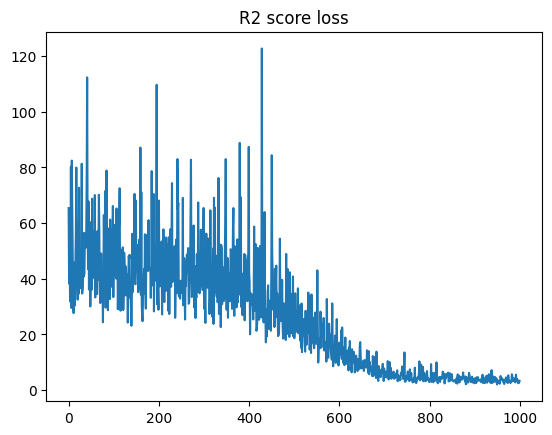

1.9975396394729614


In [22]:
loss_x = fit_model.loss_history
x = range(len(loss_x))
plt.plot(x, loss_x)
plt.title("R2 score loss")
plt.show()
print(min(loss_x))

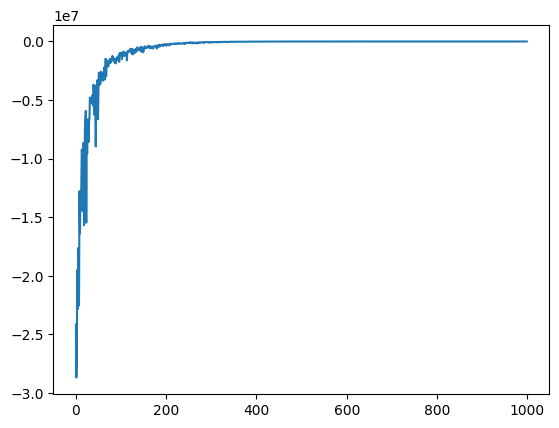

In [23]:
r2_score = fit_model.r2_score_history
x = range(len(r2_score))
plt.plot(x, r2_score)
plt.show()